<a href="https://colab.research.google.com/github/janljubas/OReL/blob/main/HA7/4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Original code

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math
from scipy import stats

class RiverSwim:
    def __init__(self, gamma=0.92):
        self.n_states = 5
        self.n_actions = 2
        self.gamma = gamma

        # Define state indices for clarity
        self.states = np.arange(self.n_states)

        # Actions: 0 = left (downstream), 1 = right (upstream)
        self.actions = [0, 1]

        # Initialize transition probabilities and rewards
        self.initialize_mdp()

        # Calculate optimal values
        self.calculate_optimal_values()

    def initialize_mdp(self):
        # P[s, a, s'] gives transition probability from s to s' under action a
        self.P = np.zeros((self.n_states, self.n_actions, self.n_states))
        self.R = np.zeros((self.n_states, self.n_actions, self.n_states))

        # Action 0 (left/downstream)
        for s in range(self.n_states):
            if s == 0:  # leftmost state
                self.P[s, 0, s] = 1.0  # stay in the same state
            else:
                self.P[s, 0, s-1] = 0.7  # move left with high probability
                self.P[s, 0, s] = 0.3    # small chance to stay

        # Action 1 (right/upstream)
        for s in range(self.n_states):
            if s == self.n_states - 1:  # rightmost state
                self.P[s, 1, s] = 0.7    # high probability to stay
                self.P[s, 1, s-1] = 0.3  # small chance to move left
                self.R[s, 1, s] = 1.0    # reward for staying in rightmost state
            elif s == 0:  # leftmost state
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.4    # decent chance to stay
                self.R[s, 1, s] = 0.05   # small reward for left state
            else:  # middle states
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.1    # small chance to stay
                self.P[s, 1, s-1] = 0.3  # decent chance to move left

    def calculate_optimal_values(self):
        """Calculate optimal state values using value iteration."""
        threshold = 1e-10
        V = np.zeros(self.n_states)

        while True:
            delta = 0
            for s in range(self.n_states):
                v = V[s]
                Q_values = np.zeros(self.n_actions)

                for a in range(self.n_actions):
                    for s_next in range(self.n_states):
                        Q_values[a] += self.P[s, a, s_next] * (self.R[s, a, s_next] + self.gamma * V[s_next])

                V[s] = np.max(Q_values)
                delta = max(delta, abs(v - V[s]))

            if delta < threshold:
                break

        self.V_star = V

        # Calculate optimal policy
        self.pi_star = np.zeros(self.n_states, dtype=int)
        for s in range(self.n_states):
            Q_values = np.zeros(self.n_actions)
            for a in range(self.n_actions):
                for s_next in range(self.n_states):
                    Q_values[a] += self.P[s, a, s_next] * (self.R[s, a, s_next] + self.gamma * V[s_next])
            self.pi_star[s] = np.argmax(Q_values)

    def step(self, state, action):
        """Take a step in the environment given state and action."""
        next_state_probs = self.P[state, action]
        next_state = np.random.choice(self.n_states, p=next_state_probs)
        reward = self.R[state, action, next_state]
        return next_state, reward

class UCBQLearning:
    def __init__(self, env, epsilon=0.13, delta=0.05, gamma=0.92, T=2000000):
        self.env = env
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.T = T

        self.n_states = env.n_states
        self.n_actions = env.n_actions

        # Initialize Q-values, visit counts, and bonus parameters
        self.Q = np.zeros((self.n_states, self.n_actions))
        self.N = np.zeros((self.n_states, self.n_actions), dtype=int)

        # Set horizon based on discount and epsilon as suggested
        self.H = int(1/(1-gamma) * np.log(1/epsilon))

    def get_ucb_bonus(self, s, a, t):
        """Calculate the UCB bonus term."""
        if self.N[s, a] == 0:
            return np.inf

        # Log term inside sqrt
        log_term = np.log(self.n_states * self.n_actions * np.log(t + 1) / self.delta)

        # Bonus term
        b = np.sqrt((self.H / self.N[s, a]) * log_term)

        return b

    def get_action(self, state, t):
        """Select action based on UCB value."""
        ucb_values = np.zeros(self.n_actions)

        for a in range(self.n_actions):
            ucb_values[a] = self.Q[state, a] + self.get_ucb_bonus(state, a, t)

        return np.argmax(ucb_values)

    def get_greedy_policy(self):
        """Return the current greedy policy based on Q-values."""
        return np.argmax(self.Q, axis=1)

    def get_policy_value(self, state, policy):
        """Calculate value of a policy from a given state."""
        V = np.zeros(self.n_states)

        # Solve the linear system for value function
        threshold = 1e-10
        while True:
            delta = 0
            for s in range(self.n_states):
                v = V[s]
                a = policy[s]

                new_v = 0
                for s_next in range(self.n_states):
                    new_v += self.env.P[s, a, s_next] * (self.env.R[s, a, s_next] + self.gamma * V[s_next])

                V[s] = new_v
                delta = max(delta, abs(v - V[s]))

            if delta < threshold:
                break

        return V[state]

    def is_eps_bad(self, state, policy):
        """Check if policy is ε-bad in given state."""
        policy_value = self.get_policy_value(state, policy)
        return policy_value < self.env.V_star[state] - self.epsilon

    def train(self, num_runs=1):
        """Train UCB-QL algorithm for multiple runs and track ε-bad timesteps."""
        all_eps_bad_counts = np.zeros((num_runs, self.T))

        for run in tqdm(range(num_runs), desc="Training runs"):
            # Reset counters and Q-values for this run
            self.Q = np.zeros((self.n_states, self.n_actions))
            self.N = np.zeros((self.n_states, self.n_actions), dtype=int)

            # Start at a random state
            current_state = np.random.randint(0, self.n_states)

            # Cumulative count of ε-bad timesteps
            eps_bad_count = 0

            for t in range(self.T):
                # Get policy (greedy with respect to Q)
                policy = self.get_greedy_policy()

                # Check if policy is ε-bad
                if self.is_eps_bad(current_state, policy):
                    eps_bad_count += 1

                # Record cumulative number of ε-bad timesteps
                all_eps_bad_counts[run, t] = eps_bad_count

                # Choose action using UCB rule
                action = self.get_action(current_state, t)

                # Take action and observe next state and reward
                next_state, reward = self.env.step(current_state, action)

                # Update visit count
                self.N[current_state, action] += 1

                # Update Q-value (using standard Q-learning update)
                best_next_q = np.max(self.Q[next_state])
                lr = 1.0 / np.sqrt(self.N[current_state, action])  # Learning rate

                # Q-learning update
                self.Q[current_state, action] += lr * (reward + self.gamma * best_next_q - self.Q[current_state, action])

                # Move to next state
                current_state = next_state

        return all_eps_bad_counts

def plot_single_run(eps_bad_counts):
    """Plot sample path of n(t) for a single run."""
    plt.figure(figsize=(10, 6))
    plt.plot(eps_bad_counts)
    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title('Sample Path of Cumulative ε-bad Timesteps')
    plt.grid(True)
    plt.savefig('single_run.png')
    plt.close()

def plot_average_with_ci(all_eps_bad_counts):
    """Plot average n(t) with 95% confidence intervals."""
    mean_counts = np.mean(all_eps_bad_counts, axis=0)
    std_counts = np.std(all_eps_bad_counts, axis=0)
    n_runs = all_eps_bad_counts.shape[0]

    # Calculate 95% confidence interval
    ci_95 = 1.96 * std_counts / np.sqrt(n_runs)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_counts, label='Average n(t)')
    plt.fill_between(np.arange(len(mean_counts)), mean_counts - ci_95, mean_counts + ci_95,
                     alpha=0.3, label='95% Confidence Interval')

    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title(f'Average Cumulative ε-bad Timesteps (over {n_runs} runs)')
    plt.legend()
    plt.grid(True)
    plt.savefig('average_run.png')
    plt.close()

def main():
    # Set parameters
    gamma = 0.92
    epsilon = 0.13
    delta = 0.05
    T = 2000  # 2 million

    # Create environment
    env = RiverSwim(gamma=gamma)

    # Create agent
    agent = UCBQLearning(env, epsilon=epsilon, delta=delta, gamma=gamma, T=T)

    # Reduced T for testing - comment this out for full run
    # T = 20000
    # agent.T = T

    # Run single iteration for part (i)
    single_run_counts = agent.train(num_runs=1)[0]
    plot_single_run(single_run_counts)

    # Run multiple iterations for part (ii)
    all_eps_bad_counts = agent.train(num_runs=100)
    plot_average_with_ci(all_eps_bad_counts)

if __name__ == "__main__":
    main()

Training runs: 100%|██████████| 100/100 [14:36<00:00,  8.77s/it]


## V2

In [6]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

class RiverSwim:
    def __init__(self, gamma=0.92, device=None):
        # Set device (GPU if available, otherwise CPU)
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.n_states = 5
        self.n_actions = 2
        self.gamma = gamma

        # Use torch tensors and move to device
        self.states = torch.arange(self.n_states, device=self.device)
        self.actions = torch.tensor([0, 1], device=self.device)

        # Initialize transition probabilities and rewards
        self.initialize_mdp()

        # Calculate optimal values
        self.calculate_optimal_values()

    def initialize_mdp(self):
        # Use torch tensors and move to device
        self.P = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)
        self.R = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)

        # Action 0 (left/downstream)
        for s in range(self.n_states):
            if s == 0:  # leftmost state
                self.P[s, 0, s] = 1.0  # stay in the same state
            else:
                self.P[s, 0, s-1] = 0.7  # move left with high probability
                self.P[s, 0, s] = 0.3    # small chance to stay

        # Action 1 (right/upstream)
        for s in range(self.n_states):
            if s == self.n_states - 1:  # rightmost state
                self.P[s, 1, s] = 0.7    # high probability to stay
                self.P[s, 1, s-1] = 0.3  # small chance to move left
                self.R[s, 1, s] = 1.0    # reward for staying in rightmost state
            elif s == 0:  # leftmost state
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.4    # decent chance to stay
                self.R[s, 1, s] = 0.05   # small reward for left state
            else:  # middle states
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.1    # small chance to stay
                self.P[s, 1, s-1] = 0.3  # decent chance to move left

    def calculate_optimal_values(self):
        """Calculate optimal state values using value iteration."""
        threshold = 1e-10
        V = torch.zeros(self.n_states, device=self.device)

        while True:
            delta = 0
            for s in range(self.n_states):
                v = V[s]
                Q_values = torch.zeros(self.n_actions, device=self.device)

                for a in range(self.n_actions):
                    for s_next in range(self.n_states):
                        Q_values[a] += self.P[s, a, s_next] * (self.R[s, a, s_next] + self.gamma * V[s_next])

                V[s] = torch.max(Q_values)
                delta = max(delta, abs(v - V[s]))

            if delta < threshold:
                break

        self.V_star = V

        # Calculate optimal policy
        self.pi_star = torch.zeros(self.n_states, dtype=torch.long, device=self.device)
        for s in range(self.n_states):
            Q_values = torch.zeros(self.n_actions, device=self.device)
            for a in range(self.n_actions):
                for s_next in range(self.n_states):
                    Q_values[a] += self.P[s, a, s_next] * (self.R[s, a, s_next] + self.gamma * V[s_next])
            self.pi_star[s] = torch.argmax(Q_values)

    def step(self, state, action):
        """Take a step in the environment given state and action."""
        next_state_probs = self.P[state, action]
        next_state = torch.multinomial(next_state_probs, 1).item()
        reward = self.R[state, action, next_state]
        return next_state, reward

class UCBQLearning:
    def __init__(self, env, epsilon=0.13, delta=0.05, gamma=0.92, T=2000000):
        self.env = env
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.T = T

        self.n_states = env.n_states
        self.n_actions = env.n_actions
        self.device = env.device

        # Initialize Q-values, visit counts, and bonus parameters using torch tensors
        self.Q = torch.zeros((self.n_states, self.n_actions), device=self.device)
        self.N = torch.zeros((self.n_states, self.n_actions), dtype=torch.long, device=self.device)

        # Set horizon based on discount and epsilon as suggested
        self.H = int(1/(1-gamma) * np.log(1/epsilon))

    def get_ucb_bonus(self, s, a, t):
        """Calculate the UCB bonus term."""
        if self.N[s, a] == 0:
            return float('inf')

        # Log term inside sqrt
        log_term = torch.log(torch.tensor(self.n_states * self.n_actions * torch.log(torch.tensor(t + 1)) / self.delta))

        # Bonus term
        b = torch.sqrt((self.H / self.N[s, a]) * log_term)

        return b.item()

    def get_action(self, state, t):
        """Select action based on UCB value."""
        ucb_values = torch.zeros(self.n_actions, device=self.device)

        for a in range(self.n_actions):
            ucb_values[a] = self.Q[state, a] + self.get_ucb_bonus(state, a, t)

        return torch.argmax(ucb_values).item()

    def get_greedy_policy(self):
        """Return the current greedy policy based on Q-values."""
        return torch.argmax(self.Q, dim=1)

    def get_policy_value(self, state, policy):
        """Calculate value of a policy from a given state."""
        V = torch.zeros(self.n_states, device=self.device)

        # Solve the linear system for value function
        threshold = 1e-10
        while True:
            delta = 0
            for s in range(self.n_states):
                v = V[s]
                a = policy[s]

                new_v = 0
                for s_next in range(self.n_states):
                    new_v += self.env.P[s, a, s_next] * (self.env.R[s, a, s_next] + self.gamma * V[s_next])

                V[s] = new_v
                delta = max(delta, abs(v - V[s]))

            if delta < threshold:
                break

        return V[state].item()

    def is_eps_bad(self, state, policy):
        """Check if policy is ε-bad in given state."""
        policy_value = self.get_policy_value(state, policy)
        return policy_value < self.env.V_star[state] - self.epsilon

    def train(self, num_runs=1):
        """Train UCB-QL algorithm for multiple runs and track ε-bad timesteps."""
        all_eps_bad_counts = torch.zeros((num_runs, self.T), device=self.device)

        for run in tqdm(range(num_runs), desc="Training runs"):
            # Reset counters and Q-values for this run
            self.Q = torch.zeros((self.n_states, self.n_actions), device=self.device)
            self.N = torch.zeros((self.n_states, self.n_actions), dtype=torch.long, device=self.device)

            # Start at a random state
            current_state = torch.randint(0, self.n_states, (1,), device=self.device).item()

            # Cumulative count of ε-bad timesteps
            eps_bad_count = 0

            for t in range(self.T):
                # Get policy (greedy with respect to Q)
                policy = self.get_greedy_policy()

                # Check if policy is ε-bad
                if self.is_eps_bad(current_state, policy):
                    eps_bad_count += 1

                # Record cumulative number of ε-bad timesteps
                all_eps_bad_counts[run, t] = eps_bad_count

                # Choose action using UCB rule
                action = self.get_action(current_state, t)

                # Take action and observe next state and reward
                next_state, reward = self.env.step(current_state, action)

                # Update visit count
                self.N[current_state, action] += 1

                # Update Q-value (using standard Q-learning update)
                best_next_q = torch.max(self.Q[next_state])
                lr = 1.0 / torch.sqrt(self.N[current_state, action].float())  # Learning rate

                # Q-learning update
                self.Q[current_state, action] += lr * (reward + self.gamma * best_next_q - self.Q[current_state, action])

                # Move to next state
                current_state = next_state

        # Move results back to CPU for plotting
        return all_eps_bad_counts.cpu().numpy()

def plot_single_run(eps_bad_counts):
    """Plot sample path of n(t) for a single run."""
    plt.figure(figsize=(10, 6))
    plt.plot(eps_bad_counts)
    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title('Sample Path of Cumulative ε-bad Timesteps')
    plt.grid(True)
    plt.savefig('single_run.png')
    plt.close()

def plot_average_with_ci(all_eps_bad_counts):
    """Plot average n(t) with 95% confidence intervals."""
    mean_counts = np.mean(all_eps_bad_counts, axis=0)
    std_counts = np.std(all_eps_bad_counts, axis=0)
    n_runs = all_eps_bad_counts.shape[0]

    # Calculate 95% confidence interval
    ci_95 = 1.96 * std_counts / np.sqrt(n_runs)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_counts, label='Average n(t)')
    plt.fill_between(np.arange(len(mean_counts)), mean_counts - ci_95, mean_counts + ci_95,
                     alpha=0.3, label='95% Confidence Interval')

    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title(f'Average Cumulative ε-bad Timesteps (over {n_runs} runs)')
    plt.legend()
    plt.grid(True)
    plt.savefig('average_run_V2.png')
    plt.close()

def main():
    # Check and print GPU availability
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(0)}")

    # Set parameters
    gamma = 0.92
    epsilon = 0.13
    delta = 0.05
    T = 2000

    # Create environment with GPU support
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = RiverSwim(gamma=gamma, device=device)

    # Create agent
    agent = UCBQLearning(env, epsilon=epsilon, delta=delta, gamma=gamma, T=T)

    # Run single iteration for part (i)
    # single_run_counts = agent.train(num_runs=1)[0]
    # plot_single_run(single_run_counts)

    # Run multiple iterations for part (ii)
    all_eps_bad_counts = agent.train(num_runs=100)
    plot_average_with_ci(all_eps_bad_counts)

if __name__ == "__main__":
    main()

CUDA available: True
Current device: 0
Device name: NVIDIA A100-SXM4-40GB


Training runs:   0%|          | 0/100 [00:00<?, ?it/s]<ipython-input-6-7504e47ca934>:118: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  log_term = torch.log(torch.tensor(self.n_states * self.n_actions * torch.log(torch.tensor(t + 1)) / self.delta))
Training runs: 100%|██████████| 100/100 [12:59<00:00,  7.80s/it]


## V3

In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class RiverSwim:
    def __init__(self, gamma=0.92, device=None):
        # Set device (GPU if available, otherwise CPU)
        self.device = device if device is not None else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.n_states = 5
        self.n_actions = 2
        self.gamma = gamma

        # Use torch tensors and move to device
        self.states = torch.arange(self.n_states, device=self.device)
        self.actions = torch.tensor([0, 1], device=self.device)

        # Initialize transition probabilities and rewards
        self.initialize_mdp()

        # Calculate optimal values
        self.calculate_optimal_values()

    def initialize_mdp(self):
        # Use torch tensors and move to device
        self.P = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)
        self.R = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)

        # Action 0 (left/downstream)
        for s in range(self.n_states):
            if s == 0:  # leftmost state
                self.P[s, 0, s] = 1.0  # stay in the same state
            else:
                self.P[s, 0, s-1] = 0.7  # move left with high probability
                self.P[s, 0, s] = 0.3    # small chance to stay

        # Action 1 (right/upstream)
        for s in range(self.n_states):
            if s == self.n_states - 1:  # rightmost state
                self.P[s, 1, s] = 0.7    # high probability to stay
                self.P[s, 1, s-1] = 0.3  # small chance to move left
                self.R[s, 1, s] = 1.0    # reward for staying in rightmost state
            elif s == 0:  # leftmost state
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.4    # decent chance to stay
                self.R[s, 1, s] = 0.05   # small reward for left state
            else:  # middle states
                self.P[s, 1, s+1] = 0.6  # move right with some probability
                self.P[s, 1, s] = 0.1    # small chance to stay
                self.P[s, 1, s-1] = 0.3  # decent chance to move left

    def calculate_optimal_values(self):
        """Calculate optimal state values using vectorized value iteration."""
        V = torch.zeros(self.n_states, device=self.device)

        # Vectorized Q-value calculation
        while True:
            # Compute Q-values for all states and actions in one go
            # Dimensions: (states, actions)
            Q_values = torch.einsum('sas,sas->sa', self.P, self.R + self.gamma * V)

            # Find max Q-value for each state
            new_V = Q_values.max(dim=1).values

            # Check convergence
            delta = torch.abs(new_V - V).max()

            # Update V
            V = new_V

            if delta < 1e-3:
                break

        self.V_star = V

        # Calculate optimal policy
        self.pi_star = Q_values.argmax(dim=1)

    def step(self, state, action):
        """Take a step in the environment given state and action."""
        next_state_probs = self.P[state, action]
        next_state = torch.multinomial(next_state_probs, 1).item()
        reward = self.R[state, action, next_state]
        return next_state, reward

class UCBQLearning:
    def __init__(self, env, epsilon=0.13, delta=0.05, gamma=0.92, T=2000000):
        self.env = env
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.T = T

        self.n_states = env.n_states
        self.n_actions = env.n_actions
        self.device = env.device

        # Initialize Q-values, visit counts, and bonus parameters using torch tensors
        self.Q = torch.zeros((self.n_states, self.n_actions), device=self.device)
        self.N = torch.zeros((self.n_states, self.n_actions), dtype=torch.long, device=self.device)

        # Set horizon based on discount and epsilon as suggested
        self.H = int(1/(1-gamma) * np.log(1/epsilon))

    def get_ucb_bonus(self, t):
        """Calculate UCB bonus for all state-action pairs."""
        # Avoid division by zero
        safe_N = torch.clamp(self.N, min=1)

        # Log term
        log_term = torch.log(
            self.n_states * self.n_actions * torch.log(torch.tensor(t + 1, device=self.device)) / self.delta
        )

        # Vectorized bonus calculation
        bonus = torch.sqrt((self.H / safe_N) * log_term)
        return bonus

    def get_policy_value(self, policy):
        """Calculate value of a policy using matrix operations."""
        # Create identity matrix to help with policy evaluation
        I = torch.eye(self.n_states, device=self.device)

        # Construct policy transition matrix and reward matrix
        P_pi = torch.zeros((self.n_states, self.n_states), device=self.device)
        R_pi = torch.zeros(self.n_states, device=self.device)

        for s in range(self.n_states):
            a = policy[s]
            P_pi[s] = self.env.P[s, a]
            R_pi[s] = torch.sum(self.env.P[s, a] * self.env.R[s, a])

        # Solve (I - γP)V = R using matrix inverse
        V = torch.linalg.solve(I - self.gamma * P_pi, R_pi)

        return V

    def train(self, num_runs=1):
        """Vectorized training of UCB-QL algorithm."""
        # Preallocate tensor for tracking ε-bad timesteps
        all_eps_bad_counts = torch.zeros((num_runs, self.T), device=self.device)

        for run in tqdm(range(num_runs), desc="Training runs"):
            # Reset for this run
            self.Q.zero_()
            self.N.zero_()

            # Start at random state
            current_state = torch.randint(0, self.n_states, (1,), device=self.device).item()
            eps_bad_count = 0

            for t in range(self.T):
                # Get current greedy policy
                policy = self.Q.argmax(dim=1)

                # Vectorized policy value calculation
                policy_values = self.get_policy_value(policy)

                # Check if policy is ε-bad for current state
                is_eps_bad = policy_values[current_state] < self.env.V_star[current_state] - self.epsilon
                if is_eps_bad:
                    eps_bad_count += 1

                # Record cumulative ε-bad timesteps
                all_eps_bad_counts[run, t] = eps_bad_count

                # UCB action selection (includes bonus)
                ucb_values = self.Q[current_state] + self.get_ucb_bonus(t)[current_state]
                action = ucb_values.argmax().item()

                # Take action
                next_state, reward = self.env.step(current_state, action)

                # Update visit count
                self.N[current_state, action] += 1

                # Learning rate
                lr = 1.0 / torch.sqrt(self.N[current_state, action].float())

                # Q-learning update
                best_next_q = self.Q[next_state].max()
                self.Q[current_state, action] += lr * (reward + self.gamma * best_next_q - self.Q[current_state, action])

                # Move to next state
                current_state = next_state

        # Move results back to CPU for plotting
        return all_eps_bad_counts.cpu().numpy()

# Plotting functions remain the same as in previous version
def plot_single_run(eps_bad_counts):
    plt.figure(figsize=(10, 6))
    plt.plot(eps_bad_counts)
    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title('Sample Path of Cumulative ε-bad Timesteps')
    plt.grid(True)
    plt.savefig('single_run_V3.png')
    plt.close()

def plot_average_with_ci(all_eps_bad_counts):
    mean_counts = np.mean(all_eps_bad_counts, axis=0)
    std_counts = np.std(all_eps_bad_counts, axis=0)
    n_runs = all_eps_bad_counts.shape[0]

    ci_95 = 1.96 * std_counts / np.sqrt(n_runs)

    plt.figure(figsize=(10, 6))
    plt.plot(mean_counts, label='Average n(t)')
    plt.fill_between(np.arange(len(mean_counts)), mean_counts - ci_95, mean_counts + ci_95,
                     alpha=0.3, label='95% Confidence Interval')

    plt.xlabel('Timestep (t)')
    plt.ylabel('Cumulative ε-bad timesteps n(t)')
    plt.title(f'Average Cumulative ε-bad Timesteps (over 100 runs)')
    plt.legend()
    plt.grid(True)
    plt.savefig('FINAL_RUN_V3.png')
    plt.close()

def main():
    # Check and print GPU availability
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"Current device: {torch.cuda.current_device()}")
        print(f"Device name: {torch.cuda.get_device_name(0)}")

    # Set parameters
    gamma = 0.92
    epsilon = 0.13
    delta = 0.05
    T = 2000000

    # Create environment with GPU support
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    env = RiverSwim(gamma=gamma, device=device)

    # Create agent
    agent = UCBQLearning(env, epsilon=epsilon, delta=delta, gamma=gamma, T=T)

    # Run single iteration for part (i)
    # single_run_counts = agent.train(num_runs=1)[0]
    # plot_single_run(single_run_counts)

    # Run multiple iterations for part (ii)
    all_eps_bad_counts = agent.train(num_runs=10)
    plot_average_with_ci(all_eps_bad_counts)

if __name__ == "__main__":
    main()

CUDA available: True
Current device: 0
Device name: NVIDIA A100-SXM4-40GB


Training runs: 100%|██████████| 10/10 [05:21<00:00, 32.17s/it]


## V4

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

class RiverSwim:
    def __init__(self, gamma=0.92, device=None):
        self.device = device if device else torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.n_states = 5
        self.n_actions = 2
        self.gamma = gamma
        self.states = torch.arange(self.n_states, device=self.device)
        self.actions = torch.tensor([0, 1], device=self.device)
        self.initialize_mdp()
        self.calculate_optimal_values()

    def initialize_mdp(self):
        self.P = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)
        self.R = torch.zeros((self.n_states, self.n_actions, self.n_states), device=self.device)

        # Action 0 (left/downstream)
        for s in range(self.n_states):
            if s == 0:
                self.P[s, 0, s] = 1.0
            else:
                self.P[s, 0, s-1] = 0.7
                self.P[s, 0, s] = 0.3

        # Action 1 (right/upstream)
        for s in range(self.n_states):
            if s == self.n_states - 1:
                self.P[s, 1, s] = 0.7
                self.P[s, 1, s-1] = 0.3
                self.R[s, 1, s] = 1.0
            elif s == 0:
                self.P[s, 1, s+1] = 0.6
                self.P[s, 1, s] = 0.4
                self.R[s, 1, s] = 0.05
            else:
                self.P[s, 1, s+1] = 0.6
                self.P[s, 1, s] = 0.1
                self.P[s, 1, s-1] = 0.3

    def calculate_optimal_values(self):
        V = torch.zeros(self.n_states, device=self.device)
        while True:
            Q = torch.einsum('sas,sas->sa', self.P, self.R + self.gamma * V)
            new_V = Q.max(dim=1).values
            if torch.abs(new_V - V).max() < 1e-3:
                break
            V = new_V
        self.V_star = V

    def step(self, state, action):
        next_state_probs = self.P[state, action]
        next_state = torch.multinomial(next_state_probs, 1).item()
        reward = self.R[state, action, next_state]
        return next_state, reward

class UCBQLearning:
    def __init__(self, env, epsilon=0.13, delta=0.05, gamma=0.92, T=2_000_000):
        self.env = env
        self.epsilon = epsilon
        self.delta = delta
        self.gamma = gamma
        self.T = T
        self.n_states = env.n_states
        self.n_actions = env.n_actions
        self.device = env.device

        # Initialize parameters as per paper
        self.H = int(np.ceil(np.log(3 / (epsilon * (1 - gamma))) / (1 - gamma)))  # Correct H
        self.Q = torch.full((self.n_states, self.n_actions), 1/(1 - gamma), device=self.device)  # Optimistic initialization
        self.N = torch.zeros((self.n_states, self.n_actions), dtype=torch.long, device=self.device)

    def get_ucb_bonus(self, t):
        """Vectorized UCB bonus calculation as per Wang et al."""
        safe_N = torch.clamp(self.N, min=1)
        log_term = torch.log((self.n_states * self.n_actions * torch.log(torch.tensor(t + 1, device=self.device)) / self.delta))
        return torch.sqrt((self.H / safe_N) * log_term)

    def train(self, num_runs=100):
        all_eps_bad = torch.zeros((num_runs, self.T // 1000), device=self.device)  # Downsampled storage

        for run in range(num_runs):
            self.Q.fill_(1/(1 - self.gamma))  # Reset Q
            self.N.zero_()
            current_state = torch.randint(0, self.n_states, (1,)).item()
            eps_bad_count = 0

            for t in tqdm(range(self.T), desc=f"Run {run+1}/{num_runs}", leave=False):
                # Get UCB values for current state
                ucb = self.Q[current_state] + self.get_ucb_bonus(t)[current_state]
                action = ucb.argmax().item()

                # Take action
                next_state, reward = self.env.step(current_state, action)
                self.N[current_state, action] += 1
                k = self.N[current_state, action]

                # Q-learning update with correct learning rate
                lr = (self.H + 1) / (self.H + k)  # Paper's α_k
                self.Q[current_state, action] += lr * (reward + self.gamma * self.Q[next_state].max() - self.Q[current_state, action])

                # Check ε-bad using UCB values (no full policy evaluation)
                current_V_ucb = self.Q[current_state].max() + self.get_ucb_bonus(t)[current_state].max()
                if current_V_ucb < self.env.V_star[current_state] - self.epsilon:
                    eps_bad_count += 1

                # Downsample: store every 1000 steps
                if t % 1000 == 0:
                    all_eps_bad[run, t // 1000] = eps_bad_count

                current_state = next_state

        return all_eps_bad.cpu().numpy()

def plot_results(data, T=2_000_000):
    plt.figure(figsize=(12, 6))
    x = np.arange(0, T, 1000) // 1000  # Plot in units of 1000 steps
    plt.plot(x, np.mean(data, axis=0), label='Average n(t)')
    plt.fill_between(x,
                     np.mean(data, axis=0) - 1.96 * np.std(data, axis=0)/np.sqrt(data.shape[0]),
                     np.mean(data, axis=0) + 1.96 * np.std(data, axis=0)/np.sqrt(data.shape[0]),
                     alpha=0.3, label='95% CI')
    plt.xlabel('Timestep (t, in thousands)')
    plt.ylabel('Cumulative ε-bad timesteps')
    plt.title(f'UCB-QL Performance (T={T//1_000}K, {data.shape[0]} runs)')
    plt.legend()
    plt.grid()
    plt.savefig('corrected_results.png')
    plt.close()

def main():
    print(f"Using device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU'}")
    env = RiverSwim(gamma=0.92, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    agent = UCBQLearning(env, T=2000000)
    data = agent.train(num_runs=10)
    plot_results(data, 2000000)

if __name__ == "__main__":
    main()

Using device: NVIDIA A100-SXM4-40GB


## V5

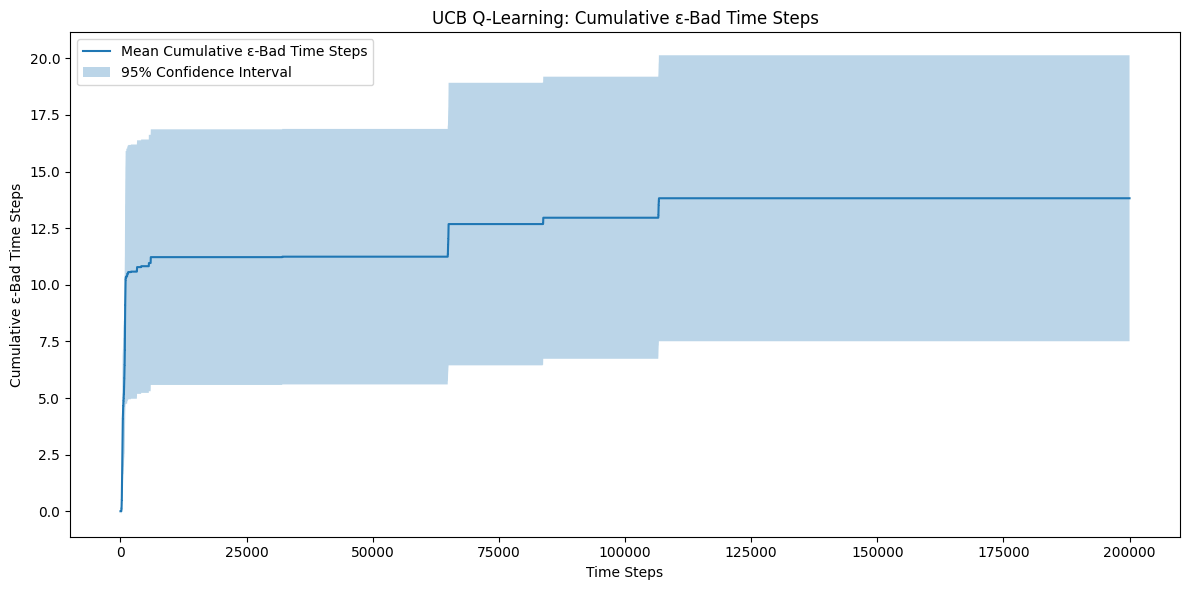

In [23]:
import numpy as np
import matplotlib.pyplot as plt

class RiverSwim:
    def __init__(self, gamma=0.92):
        self.n_states = 5
        self.n_actions = 2
        self.gamma = gamma

        # Precompute transition probabilities and rewards
        self.P = np.zeros((self.n_states, self.n_actions, self.n_states))
        self.R = np.zeros((self.n_states, self.n_actions, self.n_states))

        # Compute optimal values using value iteration
        self.compute_optimal_values()

    def compute_optimal_values(self):
        # Value iteration to compute optimal values
        V = np.zeros(self.n_states)


        while True:
            V_new = np.zeros(self.n_states)
            for s in range(self.n_states):

                # Consider both actions
                values = []

                for a in range(self.n_actions):
                    # Expected value for this action
                    v = 0
                    if s == 4 and a == 1:  # Rightmost state, upstream action
                        v = 1 + self.gamma * V[4]
                    elif s == 0 and a == 1:  # Leftmost state, upstream action
                        # Mostly stay, small chance to move right
                        v = 0.05 + 0.6 * self.gamma * V[1]
                    else:
                        # General transition probabilities
                        if a == 0:  # Left/downstream action
                            v = 0.7 * self.gamma * V[max(0, s-1)] + 0.3 * self.gamma * V[s]
                        else:  # Right/upstream action
                            if s == self.n_states - 2:
                                v = 0.6 * self.gamma * V[s+1] + 0.1 * self.gamma * V[s] + 0.3 * self.gamma * V[s-1]
                            else:
                                v = 0.6 * self.gamma * V[s+1] + 0.1 * self.gamma * V[s] + 0.3 * self.gamma * V[s-1]
                    values.append(v)
                V_new[s] = max(values)

            # Check convergence
            if np.max(np.abs(V - V_new)) < 1e-2:
                break
            V = V_new

        self.V_star = V

    def reset(self):
        # Uniform distribution over states
        return np.random.randint(0, self.n_states)

    def step(self, state, action):
        # Stochastic transitions
        if state == 4 and action == 1:  # Rightmost state, upstream action
            return 4, 1

        # Transition probabilities
        if action == 0:  # Left/downstream
            trans_probs = [0.7, 0.3] if state > 0 else [0, 1]
            next_state = max(0, state-1) if np.random.random() < 0.7 else state
            reward = 0
        else:  # Right/upstream
            if state == 0:
                trans_probs = [0.6, 0.4]
                next_state = 1 if np.random.random() < 0.6 else 0
                reward = 0.05
            elif state == 4:
                trans_probs = [0.3, 0.7]
                next_state = 3 if np.random.random() < 0.3 else 4
                reward = 1
            else:
                trans_probs = [0.3, 0.1, 0.6]
                r = np.random.random()
                if r < 0.3:
                    next_state = state-1
                elif r < 0.4:
                    next_state = state
                else:
                    next_state = state+1
                reward = 0

        return next_state, reward

class UCBQL:
    def __init__(self, n_states, n_actions, gamma, epsilon, delta, T):
        self.n_states = n_states
        self.n_actions = n_actions
        self.gamma = gamma
        self.epsilon = epsilon
        self.delta = delta
        self.T = T

        # Horizon calculation
        self.H = int(1 / (1 - gamma) * np.log(1 / epsilon))

        # Initialize Q-values optimistically
        self.Q = np.ones((n_states, n_actions)) / (1 - gamma)
        self.N = np.zeros((n_states, n_actions))

    def get_confidence_bonus(self, state, action, t):
        # UCB bonus as per the paper
        N_sa = max(1, self.N[state, action])
        log_term = np.log(self.n_states * self.n_actions * np.log(t + 1) / self.delta)
        return np.sqrt(self.H / N_sa * log_term)

    def choose_action(self, state, t):
        # UCB action selection
        bonus_values = self.Q[state, :] + [self.get_confidence_bonus(state, a, t)
                                           for a in range(self.n_actions)]
        return np.argmax(bonus_values)

    def update(self, state, action, next_state, reward, t):
        # Update visit count
        self.N[state, action] += 1
        k = self.N[state, action]

        # Learning rate as suggested in the paper
        lr = (self.H + 1) / (self.H + k)

        # Q-learning update
        self.Q[state, action] += lr * (reward + self.gamma * np.max(self.Q[next_state, :]) -
                                       self.Q[state, action])

def run_ucb_ql_experiment(T=200000, n_runs=50):
    # Experiment parameters
    gamma = 0.92
    epsilon = 0.13
    delta = 0.05

    # store cumulative epsilon-bad time steps
    all_n_t = []

    for _ in range(n_runs):

      env = RiverSwim(gamma)
      agent = UCBQL(n_states=5, n_actions=2, gamma=gamma,
                    epsilon=epsilon, delta=delta, T=T)

      # Track epsilon-bad time steps
      n_t = np.zeros(T)
      state = env.reset()

      # so this for loop is one run
      for t in range(T):
          # Choose action with UCB exploration
          action = agent.choose_action(state, t+1)

          # Take step
          next_state, reward = env.step(state, action)

          # Check if time step is epsilon-bad
          # Compare UCB Q-value estimate with true optimal value
          ucb_value = agent.Q[state, action] + agent.get_confidence_bonus(state, action, t+1)
          if ucb_value < env.V_star[state] - epsilon:
              n_t[t] = 1

          # Update Q-values
          agent.update(state, action, next_state, reward, t+1)

          # Move to next state
          state = next_state

      # now we can store the cumulative epsilon-bad time steps of this run in the collective data
      all_n_t.append(np.cumsum(n_t))



    # after all n_runs of runs are complete, compute mean and confidence intervals
    mean_n_t = np.mean(all_n_t, axis=0)
    std_n_t = np.std(all_n_t, axis=0)
    confidence_interval = 1.96 * std_n_t / np.sqrt(n_runs)

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(mean_n_t, label='Mean Cumulative ε-Bad Time Steps')
    plt.fill_between(range(T),
                     mean_n_t - confidence_interval,
                     mean_n_t + confidence_interval,
                     alpha=0.3, label='95% Confidence Interval')
    plt.title('UCB Q-Learning: Cumulative ε-Bad Time Steps')
    plt.xlabel('Time Steps')
    plt.ylabel('n(t): Cumulative ε-Bad Time Steps')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return mean_n_t, confidence_interval

# Run the experiment
mean_n_t, confidence_interval = run_ucb_ql_experiment()